# Regridding to a reference cell size using interpolation

The goal of this notebook is to demonstrate basic regridding to a reference region cell size using interpolation and correcting the total value of the variable (production, harvest).

### Description
This notebook uses multidimensional interpolation from the [xarray](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html) library and administrative area maps of countries [GADM](https://gadm.org/data.html) to define a reference region.

### Setup

First run:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample.nc

# unzip gadm
unzip gadm_0.zip

# remove zip files
rm *.zip
```

The above shell commands will download and unzip a GADM shape file for countries of the world and a sample NetCDF file based on the LPJmL model's output.

### Requirements
```
geopandas==0.9.0
matplotlib==3.4.2
numpy==1.20.3
rioxarray==0.7.1
xarray==0.18.2
```

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import geopandas as gpd

### Load and plot the netCDF dataset using xarray.

In [3]:
ds = xr.open_dataset('sample.nc', engine='netcdf4', decode_coords="all")
ds = ds.rio.write_crs(4326)
# Drop time variables; for some reason clipping these is problematic...
ds = ds[['harvested_area','harvest','production']]

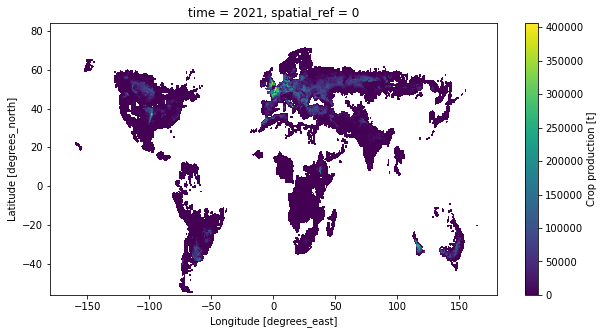

In [4]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ds.production[0,0,:,:].plot(ax=axes)

### Load and filter the GADM data for countries of interest.

In [5]:
shapefile = '/home/user/Downloads/geo/gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)
sf.head()

,GID_0,NAME_0,geometry
0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,"POLYGON ((68.52644 31.75435, 68.53852 31.75457..."
2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Åland,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


<AxesSubplot:>

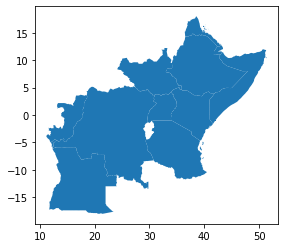

In [6]:
countries = ['Ethiopia','South Sudan','Somalia','Kenya', 'Eritrea', 'Uganda', 'Djibouti','Tanzania','Zaire','Angola',
            'Republic of Congo','Democratic Republic of the Congo']
countries_shp = sf[sf['NAME_0'].isin(countries)]
countries_shp.plot()

### Clip the dataset to the bounds of the countries of interest.

In [7]:
ds_c = ds.rio.clip(countries_shp.geometry)

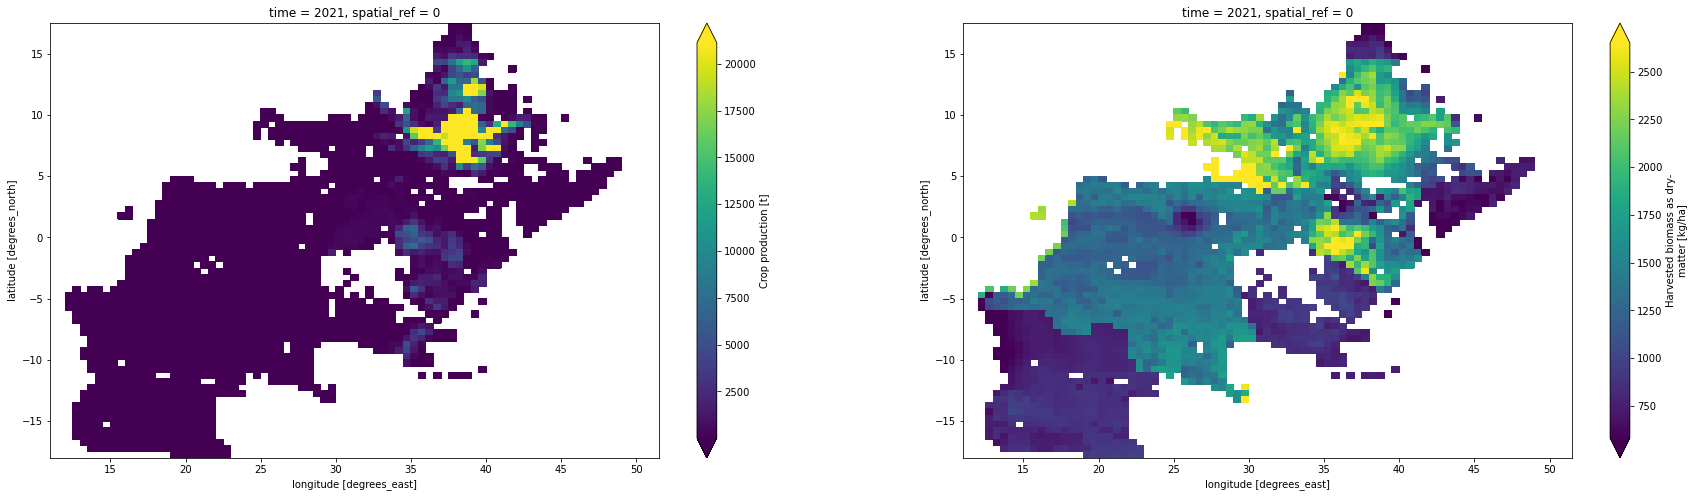

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))

ds_c.isel(crop=0, time=0)['production'].plot(ax=axes[0], robust=True)
ds_c.isel(crop=0, time=0)['harvest'].plot(ax=axes[1],robust=True)
print()

### Increase the resolution of the data by interpolating to a grid with 5-times the number of points.
Because interpolation averages the data, manually set the result dataset values to the total corrected for the change in area.

In [9]:
multiplier = 5
new_lon = np.linspace(ds_c.longitude[0], ds_c.longitude[-1], round(ds_c.dims["longitude"] * multiplier))
new_lat = np.linspace(ds_c.latitude[0], ds_c.latitude[-1], round(ds_c.dims["latitude"] * multiplier))
ds2 = ds_c.interp(latitude=new_lat, longitude=new_lon)
ds2['production'] = ds2['production'] / multiplier
ds2['harvest'] = ds2['harvest'] / multiplier

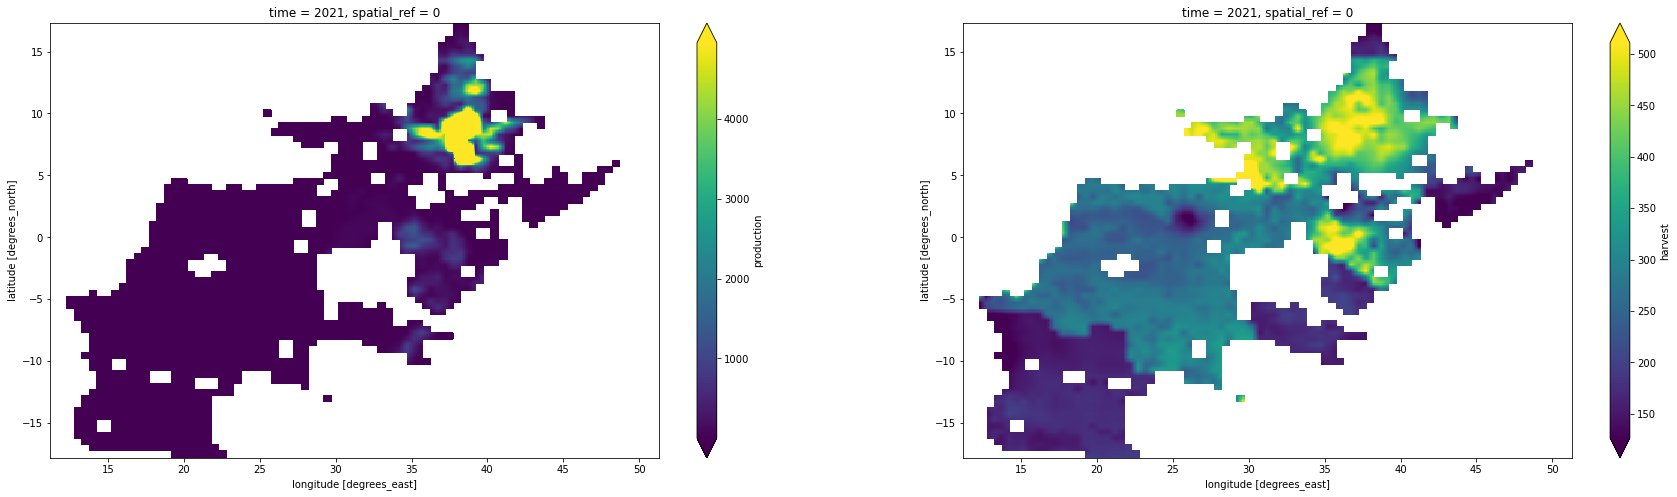

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))

ds2.isel(crop=0, time=0)['production'].plot(ax=axes[0], robust=True)
ds2.isel(crop=0, time=0)['harvest'].plot(ax=axes[1],robust=True)
print()